In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
BASE_DIR  = "./data"
labels = pd.read_csv(f"{BASE_DIR}/train_labels.csv", parse_dates=["datetime"])
sample_submission = pd.read_csv(f"{BASE_DIR}/sample_submission.csv")

# Player tracking data
train_tracking = pd.read_csv(f"{BASE_DIR}/train_player_tracking.csv", parse_dates=["datetime"])
test_tracking = pd.read_csv(f"{BASE_DIR}/test_player_tracking.csv", parse_dates=["datetime"])
# Baseline helmet detection labels
train_helmet = pd.read_csv(f"{BASE_DIR}/train_baseline_helmets.csv")
test_helmet = pd.read_csv(f"{BASE_DIR}/test_baseline_helmets.csv")
# Video meta data 
train_video_metadata = pd.read_csv(f"{BASE_DIR}/train_video_metadata.csv",parse_dates=["start_time", "end_time", "snap_time"])

parse_dates: change `2020-09-11T03:01:48.100Z` to `2020-09-11 03:01:48.100000+00:00`

In [10]:
import cv2 
import os
import subprocess

In [20]:
def video_with_helmets(video_path: str, baseline_boxes: pd.DataFrame, verbose=True)->str:
    video_name = os.path.basename(video_path)
    VIDEO_CODEC = "MP4V"
    HELMET_COLOR = (0, 0, 0)
    if verbose:
        print(f"Running for {video_name}")
    baseline_boxes = baseline_boxes.copy() # create a copy 
    # get the video 
    vidcap = cv2.VideoCapture(video_path)
    # get info of the video 
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    output_path = "labeled_" + video_name
    tmp_output_path = "tmp_" + output_path
    output_video = cv2.VideoWriter(
        tmp_output_path, cv2.VideoWriter_fourcc(*VIDEO_CODEC), fps, (width, height)
    ) 
    # create a video writer 
    frame = 0
    while True:
        worked_frame, img = vidcap.read()
        if not worked_frame:
            break
        frame += 1 # the frame starts from 1
        # Let's add a frame index to the video so we can track where we are
        img_name = video_name.replace(".mp4", "")
        cv2.putText(
            img,
            img_name,
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            HELMET_COLOR,
            thickness=1,
        ) # this put the img_name (without the tail) on the top left corner

        cv2.putText(
            img,
            str(frame),
            (1280 - 90, 720 - 20),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            HELMET_COLOR,
            thickness=1,
        ) # this put the frame number on the bottom right corner
        
        
        # get all the boxes for this frame in this video
        boxes = baseline_boxes[(baseline_boxes["frame"] == frame) & (baseline_boxes["video"] == video_name)]
        for box in boxes.itertuples(index=False): # iterate over the boxes 
            # draw the box/rectangle
            cv2.rectangle(
                img,
                (int(box.left), int(box.top)),
                (int(box.left + box.width), int(box.top + box.height)),
                HELMET_COLOR,
                thickness=1,
            )
            # write the player label
            cv2.putText(
                img,
                box.player_label,
                (int(box.left), int(box.top)),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                HELMET_COLOR,
                thickness=1,
            )
        output_video.write(img)
    output_video.release()
    if os.path.exists(output_path):
        os.remove(output_path)
        
    subprocess.run(
        [
            "ffmpeg",
            "-i",
            tmp_output_path,
            "-crf",
            "18",
            "-preset",
            "veryfast",
            "-hide_banner",
            "-loglevel",
            "error",
            "-vcodec",
            "libx264",
            output_path,
        ]
    )
    os.remove(tmp_output_path)

    return output_path

In [136]:
example_video = "data/train/58168_003392_Sideline.mp4"
output_video = video_with_helmets(example_video, train_helmet, verbose=True)

frac = 0.65  # scaling factor for display
display(
    Video(data=output_video, embed=True, height=int(720 * frac), width=int(1280 * frac))
)

In [23]:
import matplotlib.patches as patches


In [115]:
def create_football_field(
    linenumbers=True,
    endzones=True,
    figsize=(12, 6.33),
    line_color="black",
    field_color="white",
    ez_color=None,
    ax=None,
    return_fig=False,
):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    if ez_color is None:
        ez_color = field_color

    width = 120
    length = 53.3
    rect = patches.Rectangle(
        (0, 0),
        width,
        length,
        linewidth=0.1,
        edgecolor="r",
        facecolor=field_color,
        zorder=0,
    ) # Field Rectangle

    if ax is None:
        fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)
    
    # draw the field and line in field 
    for x in range(0, width+10, 10):
        ax.plot([x, x], [0, length], line_color)
    ax.plot([0, width], [0,0], line_color)
    ax.plot([0, width], [length, length], line_color)
    # ax.axis("off")
    
    if endzones:
        ez1 = patches.Rectangle(
            (0, 0), 10, length, linewidth=0.1, edgecolor="r", facecolor=ez_color, zorder=0
        )
        ez2 = patches.Rectangle(
            (width-10, 0), 10, length, linewidth=0.1, edgecolor="r", facecolor=ez_color, zorder=0
        )
        ax.add_patch(ez1)
        ax.add_patch(ez2)
        
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            ax.text(
                x,
                5,
                str(numb - 10),
                horizontalalignment="center",
                fontsize=20,  # fontname='Arial',
                color=line_color,
            )
            ax.text(
                x - 0.95,
                53.3 - 5,
                str(numb - 10),
                horizontalalignment="center",
                fontsize=20,  # fontname='Arial',
                color=line_color,
                rotation=180,
            )
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)
    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color=line_color)
        ax.plot([x, x], [53.0, 52.5], color=line_color)
        ax.plot([x, x], [22.91, 23.57], color=line_color)
        ax.plot([x, x], [29.73, 30.39], color=line_color)
        
    border = patches.Rectangle(
        (-5, -5),
        width + 10,
        length + 10,
        linewidth=0.1,
        edgecolor="orange",
        facecolor=line_color,
        alpha=0.05,
        zorder=0,
    )
    ax.add_patch(border)
    ax.set_xlim((-5, width+5))
    ax.set_ylim((-5, length + 5))

    if return_fig:
        return fig, ax
    else:
        return ax
    
    

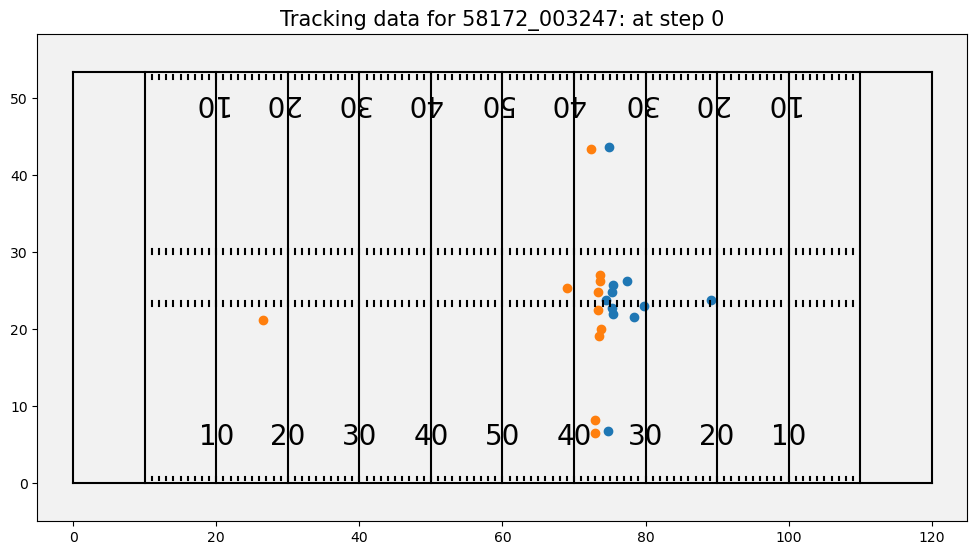

In [120]:
game_play = "58172_003247"
example_track = train_tracking[(train_tracking["game_play"]==game_play) & (train_tracking["step"]==0)]
# print(example_track.head())
ax = create_football_field()
for team, data in example_track.groupby("team"):
    ax.scatter(data["x_position"], data["y_position"], label=team) # scatter the posi of player
ax.legend().remove() # remove legend 
ax.set_title(f"Tracking data for {game_play}: at step 0", fontsize=15) # set title 
plt.show()

In [134]:
train_helmet.head()

,game_play,game_key,play_id,view,video,frame,nfl_player_id,player_label,left,width,top,height
0,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,39947,H72,946,25,293,34
1,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,37211,H42,151,25,267,33
2,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,38590,H70,810,25,293,35
3,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,44822,H15,681,26,254,33
4,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,41944,V92,680,23,303,33


In [142]:
def join_helmets_contact(game_play, labels, helmets, meta, view="Sideline", fps=59.94):
    gp_labels = labels[labels["game_play"] == game_play]
    gp_helmets = helmets[helmets["game_play"] == game_play]
    start_time = meta[(meta["game_play"] == game_play) & (meta["view"]==view)]["start_time"].values[0]
    
    gp_helmets["datetime"] = (
        pd.to_timedelta(gp_helmets["frame"] * (1 / fps), unit="s") + start_time
    ) # get the end time 
    gp_helmets["datetime"] = pd.to_datetime(gp_helmets["datetime"], utc=True) # convert to datetime
    gp_helmets["datetime_ngs"] = (
        pd.DatetimeIndex(gp_helmets["datetime"]+pd.to_timedelta(50,"ms")).round("100ms").values
    ) #  aligning video data 
    gp_helmets["datetime_ngs"] = pd.to_datetime(gp_helmets["datetime_ngs"], utc=True) #convert to datetime
    gp_labels["datetime_ngs"] = pd.to_datetime(gp_labels["datetime"], utc=True) #convert to datetime
    gp = gp_helmets.merge(
        gp_labels[gp_labels["contact"] == 1][
            ["datetime_ngs", "nfl_player_id_1", "nfl_player_id_2", "contact_id"]
        ], # get the gb_labels where player has contact, and get 4 cols like above 
        left_on=["datetime_ngs", "nfl_player_id"], # the helmet columns to merge is datatime and nfl_player_id
        right_on=["datetime_ngs", "nfl_player_id_1"], # the label columns to merge is datatime and nfl_player_id_1
        how="left", # keep the helmet the same
    )
    # overall, the merge above will find in the same time, which ...
    # ... player has made contact with player 2, add that player 2 to the helmet df
    # if in that time, the player has no contact, the player 2 will be NaN
    # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html 
    return gp

    

In [151]:
def video_with_contact(video_path: str, baseline_boxes: pd.DataFrame, verbose=True) -> str:
    video_name = os.path.basename(video_path)
    VIDEO_CODEC = "MP4V"
    HELMET_COLOR = (0, 0, 0)
    if verbose:
        print(f"Running for {video_name}")
    baseline_boxes = baseline_boxes.copy() # create a copy 
    # get the video 
    vidcap = cv2.VideoCapture(video_path)
    # get info of the video 
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    output_path = "labeled_" + video_name
    tmp_output_path = "tmp_" + output_path
    output_video = cv2.VideoWriter(
        tmp_output_path, cv2.VideoWriter_fourcc(*VIDEO_CODEC), fps, (width, height)
    ) 
    # create a video writer 
    frame = 0
    while True:
        worked_frame, img = vidcap.read()
        if not worked_frame:
            break
        frame += 1 # the frame starts from 1
        # Let's add a frame index to the video so we can track where we are
        img_name = video_name.replace(".mp4", "")
        cv2.putText(
            img,
            img_name,
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            HELMET_COLOR,
            thickness=1,
        ) # this put the img_name (without the tail) on the top left corner

        cv2.putText(
            img,
            str(frame),
            (1280 - 90, 720 - 20),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            HELMET_COLOR,
            thickness=1,
        ) # this put the frame number on the bottom right corner
        
        
        # get all the boxes for this frame in this video
        boxes = baseline_boxes[(baseline_boxes["frame"] == frame) & (baseline_boxes["video"] == video_name)]
        contact_players = boxes.dropna(subset=["nfl_player_id_2"]).query("nfl_player_id_2 != 'G'") # G stands for ground
        
        contact_ids = (
            contact_players["nfl_player_id_1"].astype("int").values.tolist()
            + contact_players["nfl_player_id_2"].astype("int").values.tolist()
        )
        for box in boxes.itertuples(index=False): # iterate over the boxes 
            if box.nfl_player_id_2 == "G":
                box_color = (0, 0,255) # red for ground
                box_thickness = 2
            elif int(box.nfl_player_id) in contact_ids:
                box_color = (0, 255, 0) # green for contact
                box_thickness = 2
                # check nan for player 2 
                if not np.isnan(float(box.nfl_player_id_2)):
                    player2 = int(box.nfl_player_id_2)
                    player2_row = boxes.query("nfl_player_id == @player2") # find all the player2 
                    if len(player2_row) == 0:
                        # Player 2 is not in view
                        continue 
                    ## add a line between player 1 and player 2
                    cv2.line(
                        img,
                        (box.left + int(box.width / 2), box.top + int(box.height / 2)),
                        (
                            player2_row.left.values[0]
                            + int(player2_row.width.values[0] / 2),
                            player2_row.top.values[0]
                            + int(player2_row.height.values[0] / 2),
                        ),
                        color=(255, 0, 0), #blue for the connect line
                        thickness=2,
                    )
            else:
                box_color = HELMET_COLOR
                box_thickness = 1
            # draw the box/rectangle
            cv2.rectangle(
                img,
                (box.left, box.top),
                (box.left + box.width, box.top + box.height),
                box_color,
                thickness=box_thickness,
            )
            cv2.putText(
                img,
                box.player_label,
                (box.left + 1, max(0, box.top - 20)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                HELMET_COLOR,
                thickness=1,
            )
        output_video.write(img)
    output_video.release()
    print("release")
    if os.path.exists(output_path):
        os.remove(output_path)
        
    subprocess.run(
        [
            "ffmpeg",
            "-i",
            tmp_output_path,
            "-crf",
            "18",
            "-preset",
            "veryfast",
            "-hide_banner",
            "-loglevel",
            "error",
            "-vcodec",
            "libx264",
            output_path,
        ]
    )
    os.remove(tmp_output_path)

    return output_path
    
    

In [144]:
# import Video 
from IPython.display import Video, display

In [153]:
labelsgame_play = "58168_003392"
gp = join_helmets_contact(game_play, labels, train_helmet, train_video_metadata)
# gp has the all the boxes and the contact info
example_video = f"data/train/{game_play}_Sideline.mp4"
output_video = video_with_contact(example_video, gp)
frac = 0.65  # scaling factor for display
display(
    Video(data=output_video, embed=True, height=int(720 * frac), width=int(1280 * frac))
)